# Optimization hardness in biological transients

[Link to live notebook](https://colab.research.google.com/github/williamgilpin/illotka/blob/main/demos.ipynb)

[Link to static webpage](http://www.wgilpin.com/illotka/demos.html)

[Paper](https://journals.plos.org/ploscompbiol/)

### Preamble

+ After opening this notebook, run the cells below before anything else. These will import libraries and define functions.

+ This notebook requires the following packages, which are pre-installed on Google Colab.

    + Python 3
    + NumPy
    + SciPy
    + Matplotlib

In [ ]:
## Preamble / required packages
import numpy as np
from IPython.display import Image
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
## default first plot color is black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['k'])  # Set default plot color to black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Reset to default colors
plt.rcParams['legend.frameon'] = False

## Disable warnings
import warnings
warnings.filterwarnings('ignore')

# !apt-get install nvidia-cuda-toolkit
# !pip3 install numba
## These lines allow Google Colab to import and work with external files.
# %rm -rf illotka
# !git clone https://github.com/williamgilpin/illotka.git
# %cd illotka
# import importlib.util, sys
# module_path = "/content/illotka/base.py"
# spec = importlib.util.spec_from_file_location("base", module_path)
# base = importlib.util.module_from_spec(spec)
# sys.modules["base"] = base
# spec.loader.exec_module(base)

# import requests
# url = "https://raw.githubusercontent.com/williamgilpin/illotka/main/base.py"
# resp = requests.get(url)
# resp.raise_for_status()
# with open("base.py", "w") as f:
#     f.write(resp.text)

# url = "https://raw.githubusercontent.com/williamgilpin/illotka/main/utils.py"
# resp = requests.get(url)
# resp.raise_for_status()
# with open("utils.py", "w") as f:
#     f.write(resp.text)


from base import *
from utils import *

# Autoreload
%load_ext autoreload
%autoreload 2
print("Loading complete")

Loading complete


# Revisiting stability vs. complexity

+ Biological systems

+ May 1972: We expect large ecosystems to be unstable. If we assume that the interaction matrix $A$ is drawn from a normal distribution, then the steady-state solution is given by

$$
    \frac{dN_i}{dt} = \sum_{j=1}^N A_{ij} N_j 
$$

where $\mathbf{N} = (N_1, N_2, \cdots, N_N)$ is the vector of species abundances, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$.





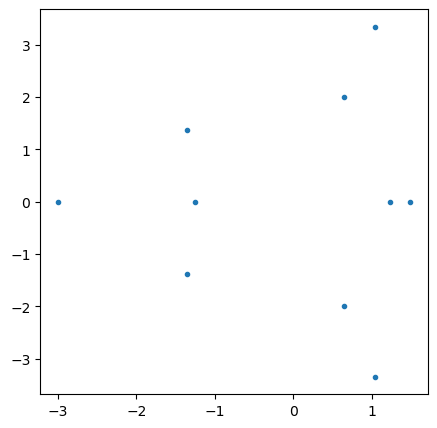

In [194]:
A = np.random.normal(size=(10, 10))
eigvals = np.linalg.eigvals(A)

plt.figure(figsize=(5, 5))
plt.plot(eigvals.real, eigvals.imag, '.')

# np.max(np.real(np.linalg.eigvals(A)))


## The generalized Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$.

To study the behavior of this model, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form 

$$
    A = Q - d\, I
$$
where $I \in \mathbb{R}^{N \times N}$ is the identity matrix, $Q_{ij} \sim \mathcal{N}(0,1)$ and $d$ is a constant density-limitation.




(0.0, 0.6341573011172086)

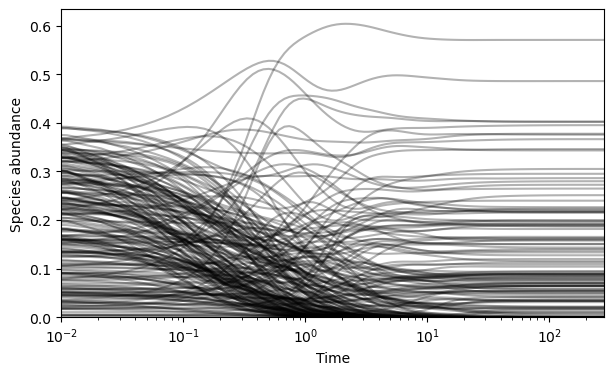

In [2]:
# Set the simulation parameters
tmax = 20000 # Maximum integration duration
n = 200 # Number of species
d = 12.5 # Density-limitation

## Initialize the model
eq = GaussianLotkaVolterra(n)
eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

## Initial conditions
ic = 0.4 *np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(t))
plt.ylim(0, None)



### How many species survive?

In [3]:
nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

106 species out of 200 remain


## We repeat the experiment many times

[################### ] 



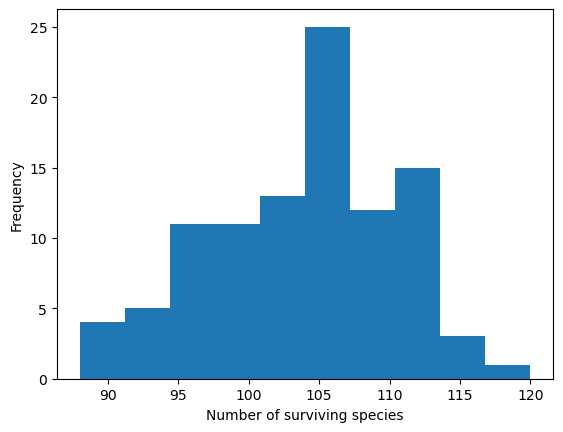

In [5]:
n_replicates = 20
tmax = 1000

number_survive = []
for i in prange(n_replicates):
    progress_bar(i, n_replicates) # Print progress bar for loop

    eq = GaussianLotkaVolterra(n)
    eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
    # eq.A = eq.A * np.identity(n) # Wipe out all off-diagonal elements
    eq.r = np.random.normal(size=n)
    t, y = eq.integrate(tmax, ic)

    n_survive = np.sum(y[-1] > 1e-12)
    number_survive.append(n_survive)

plt.hist(number_survive)
plt.xlabel("Number of surviving species");
plt.ylabel("Frequency");


In [31]:
print(np.mean(number_survive))
print(np.std(number_survive))

103.66
6.259744403727679


In [32]:
print(0.5 * n)
print(np.sqrt(n * 0.5 * (1 - 0.5)))

100.0
7.0710678118654755


### Properties of the Random Lotka-Volterra model

Proven in [Serván et al. 2018](https://www.nature.com/articles/s41559-018-0603-6).

1. On average, half of all species survive at steady-state. Across replicates, the number of surviving species follows a binomial distribution with mean $n/2$.
2. For a given matrix $A$, the steady-state solution is unique (global attractor).
3. For a given matrix $A$, there always exists a density-limitation $d$ that that leads to a single stable steady-state.

Main assumption: Interactions and growth rates are drawn from a symmetric distribution with finite variance.


<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

## How do extreme values affect the dynamics?

The generalized normal distribution is parametrized by shape parameter $\beta$, which controls the tail thickness. It is given by

$$
    p(x) = \frac{\beta}{2\sigma\Gamma(1/\beta)} e^{-\left(\frac{|x-\mu|}{\sigma}\right)^\beta}
$$

+ when $\beta < 1$, the distribution has fatter tails than the normal distribution.
+ when $\beta > 1$, the distribution has lighter tails than the normal distribution.


156 species out of 300 remain


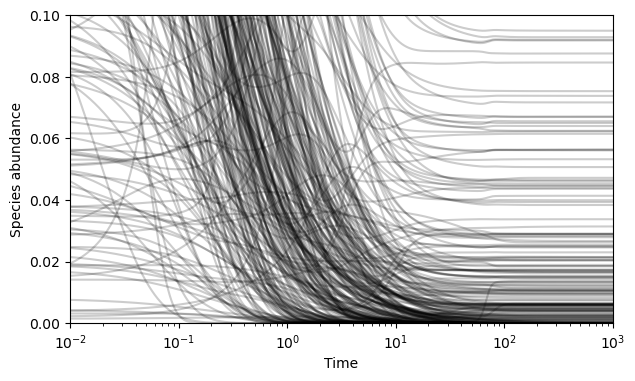

In [30]:
# Set the simulation parameters
tmax = 10000 # Maximum integration duration
n = 300 # Number of species
d = 18 # Density-limitation
seed = 0 # Seed for random number generator
# seed = None

## Initialize the model
np.random.seed(seed)
eq = GaussianLotkaVolterra(n, random_state=seed, tolerance=1e-10)

## Sample the interaction matrix from a normal distribution
# eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
# eq.r = np.random.normal(size=n)

## Sample the interaction matrix from a modified normal distribution
eq.A = 1.5 * normal_generalized(size=(n, n)) - d * np.identity(n)
eq.r = normal_generalized(size=n)

## Random initial conditions
ic = 0.5 * np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

## Plot the results
plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.2);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, 1000)
plt.ylim(0, 0.1)


nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>


## How long to reach steady-state?

Given a steady-state solution $\mathbf{N}^*$, the *settling time* is the time it takes for the solution to reach the steady-state within a given tolerance $\epsilon$.

$$
    \text{argmin}_{t} \bigg( \dfrac{\| \mathbf{N}(t) - \mathbf{N}^* \|}{\| \mathbf{N}(t) \|} < \epsilon \bigg)
$$




In [41]:
def compute_settling_time(traj, tvals=None, eps=1e-6):
    """
    Compute the settling time from a multivariate time series. 
    If the trajectory does not reach the steady-state within the integration time, 
    return a NaN.
    """
    final_value = traj[-1]
    scaled_distance = (np.linalg.norm(traj - final_value, axis=1)) / np.linalg.norm(traj, axis=1)
    final_index = np.where(scaled_distance < eps)[0]
    if len(final_index) == 0:
        return np.nan
    else:
        return final_index[0]



## Initialize the model
np.random.seed(seed)
eq = GaussianLotkaVolterra(n, random_state=seed, tolerance=1e-10)

## Sample the interaction matrix from a modified normal distribution
eq.A = 1.5 * normal_generalized(size=(n, n), beta=1) - d * np.identity(n)
eq.r = normal_generalized(size=n)

## Random initial conditions
ic = 0.5 * np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

tind = compute_settling_time(y)
print(f"Settling time: {t[tind]:.2f}")
nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

Settling time: 585.71
146 species out of 300 remain


# Hierarchical structure in the Lotka-Volterra model

*Trophic interactions* can produce extremal values in the Lotka-Volterra model. We consider sampling a family of matrices of the form

$$
    A = P^\top (A^{(0)} - d\, I) P + \epsilon \, E,
$$


+ As before,$A^{(0)}_{ij},  r_i \sim \mathcal{N}(0, 1)$

+ $P \in \mathbb{R}^{N \times N}$ is a low-rank assigment matrix describing functional redundancy or trophic levels among species. 

+ $E \in \mathbb{R}^{N \times N}$ is a matrix of random noise that prevents exact redundancy.
+ $\epsilon \ll 1$ is a small constant that controls the degree to which redundant species deviate from exact redundancy.

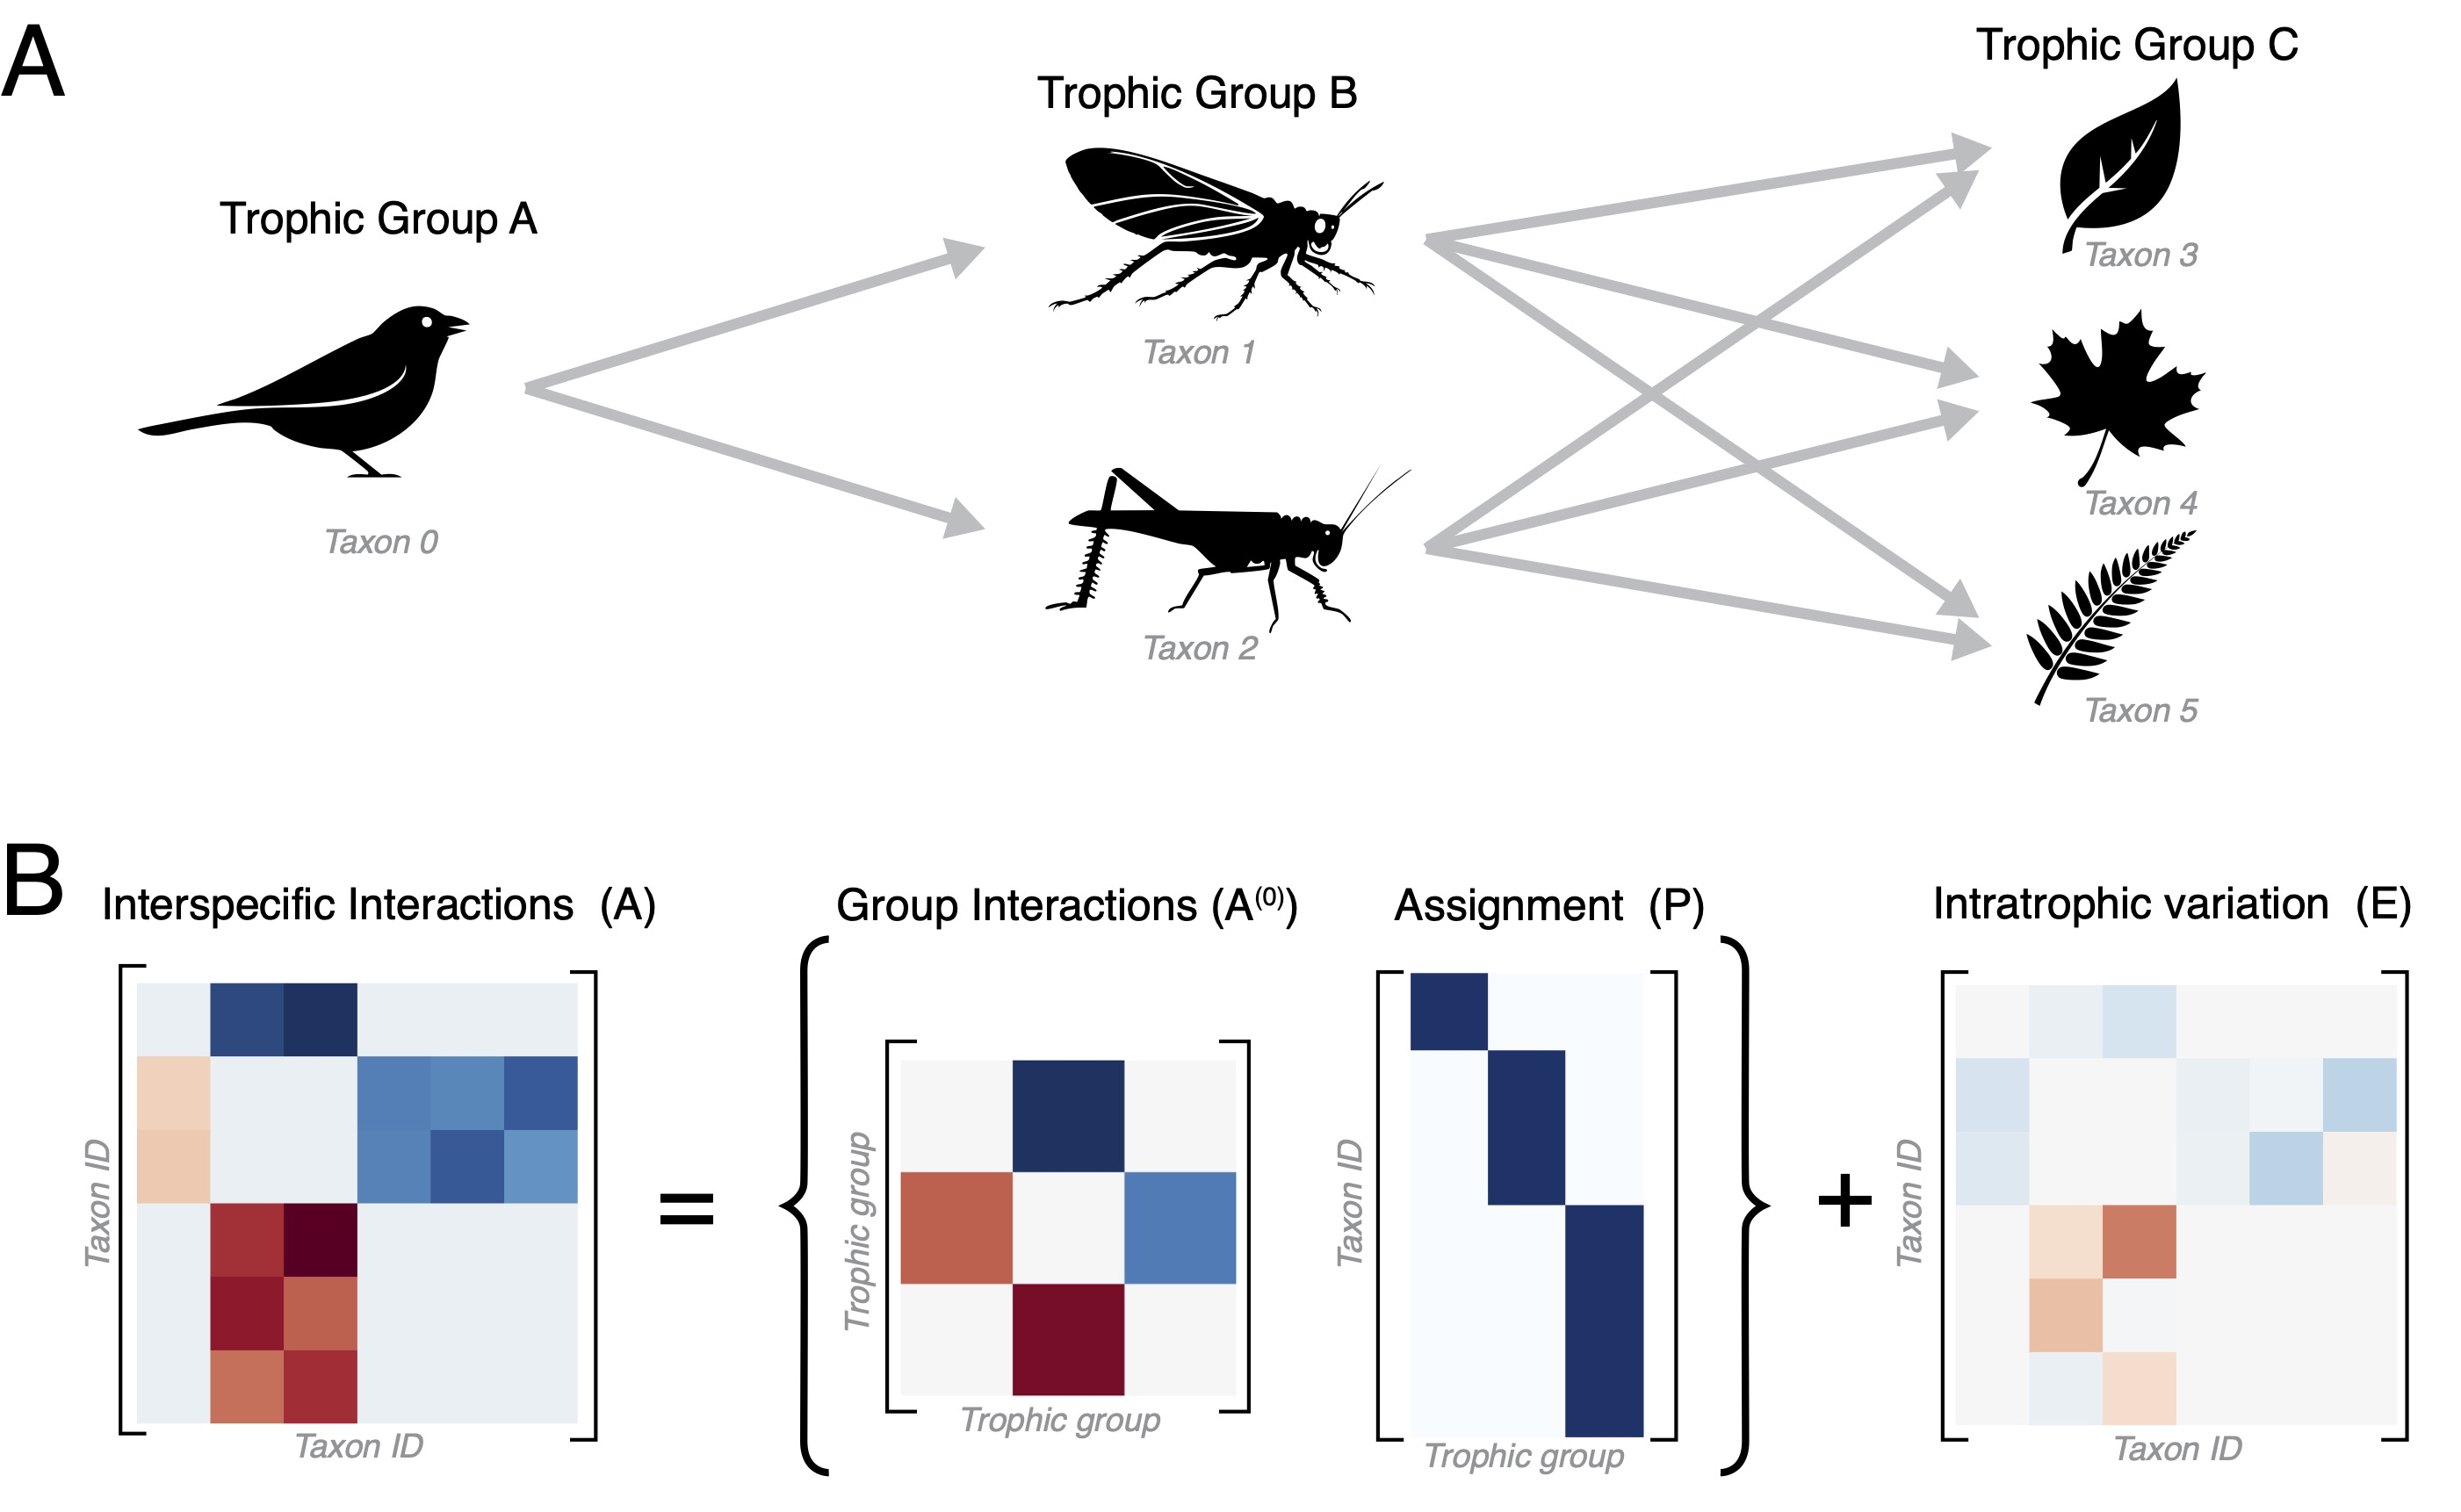

In [ ]:

## Loads a figure from the resources folder
Image("./resources/fig_model.jpg", width=1200)

For an analysis of equilibrium properties of a Lotka-Volterra model with hierarchical structure like this, see [Tikhonov (2017)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.032410).

<br/><br/>
<br/><br/>
<br/><br/>


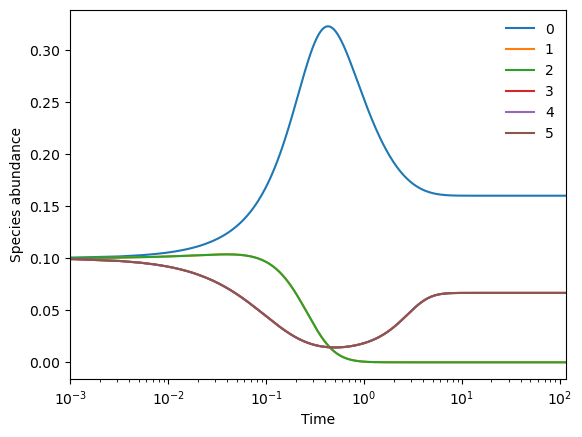

In [160]:
m_trophs = 3
n_species = 6
tmax = 1e8

interactions_trophic = np.array([
    [0, 0.5, 0],
    [-0.5, 0, 0.3],
    [0, -0.8, 0],
])*50

p_mat = np.array(
    [[1, 0, 0, 0, 0, 0],
     [0, 1, 1, 0, 0, 0],
     [0, 0, 0, 1, 1, 1]]
)


eq = RandomLotkaVolterra(n_species)
eq.r = np.array([0.8, 0.9, 1]) @ p_mat
eq.A = p_mat.T @ (interactions_trophic - 5*np.identity(m_trophs)) @ p_mat #+ 1e-6 * np.random.normal(size=(n_species, n_species))

ic = np.ones(n_species) * 0.1
t, y = eq.integrate(tmax, ic)

plt.semilogx(t, y);
plt.legend(np.arange(n_species), frameon=False);
plt.xlim(1e-3, t[-1]);
plt.xlabel("Time");
plt.ylabel("Species abundance");


<br/><br/>
<br/><br/>


### Larger ecosystems

+ Instead of imposing a specific functional redundancy, we'll sample the assignment matrix $P$ from a family of random low-rank matrices.

+ The small parameter $\epsilon$ controls the degree to which redundant species deviate from exact redundancy.

(0.001, np.float64(145205.60974303592))

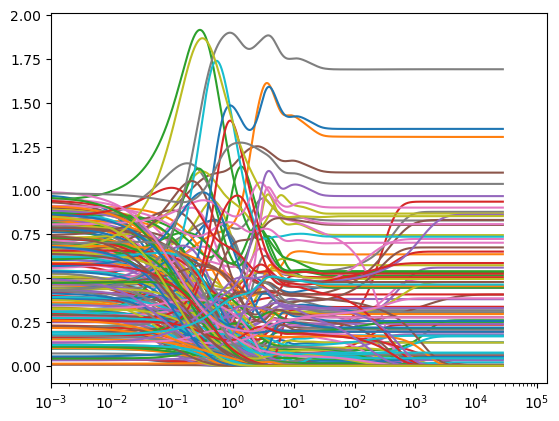

In [9]:
tmax = 1e8
n_val = 200

ic = np.random.uniform(size=n_val)
eq = RandomLotkaVolterra(n_species=200, eps=1e-3)
t, y = eq.integrate(tmax, ic)
plt.semilogx(t, y);
plt.xlim(1e-3, None)

eps: 1e-05
eps: 3.5938136638046256e-05
eps: 0.0001291549665014884
eps: 0.0004641588833612782
eps: 0.0016681005372000592
eps: 0.005994842503189409
eps: 0.021544346900318846
eps: 0.07742636826811278
eps: 0.2782559402207126
eps: 1.0


Text(0, 0.5, 'Settling Time')

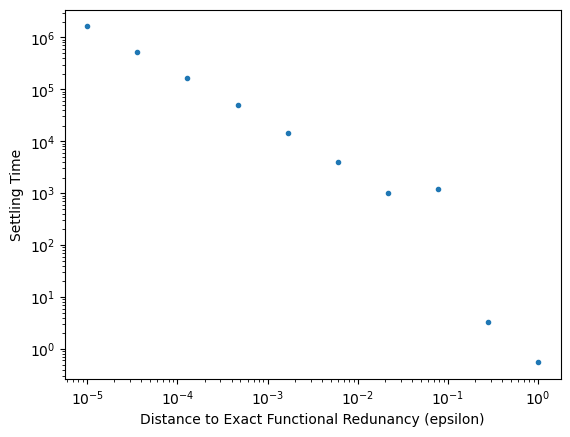

In [159]:

tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
for eps in eps_vals:
    print(f"eps: {eps}")
    eq = RandomLotkaVolterra(n_val, random_state=0, eps=eps,  sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])


plt.loglog(eps_vals, settling_times, '.')
plt.xlabel("Distance to Exact Functional Redunancy (epsilon)")
plt.ylabel("Settling Time")

<br/><br/>
<br/><br/>
<br/><br/>

# The Lotka-Volterra model as analogue linear regression


We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$. The steady-state solutions of this equation has the form

+ Without the outer term, the Lotka-Volterra model is a linear time-invariant system. 

+ The solution to the Lotka-Volterra model is the solution to the linear system $A \mathbf{N}^* = -\mathbf{r}$.

+ The outer term adds a positivity constraint. In practice, this leads to sparsity (exclusion) in the steady-state solution $\mathbf{N}^*$.


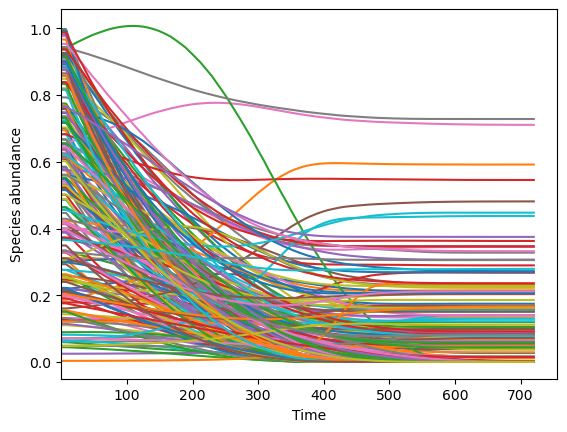

In [ ]:
eq = RandomLotkaVolterra(n_val, random_state=3, eps=1e0, sigma=0.5, d=4.5, kfrac=0.0, connectivity=0.05)
ic = np.random.uniform(size=n_val)
t, y = eq.integrate(tmax, ic, tol=1e-10)
plt.plot(y);
plt.xlim(1e-3, None)
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.show()


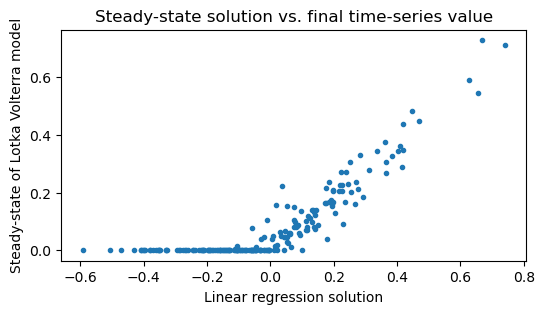

Text(0.5, 1.0, 'Correlation: 0.81')

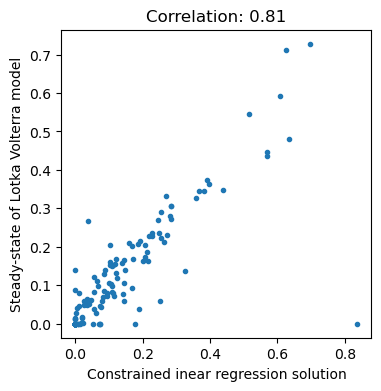

In [162]:
## Perform unconstrained linear regression
plt.figure(figsize=(6, 3))
plt.plot(np.linalg.solve(eq.A, -eq.r), y[-1], '.')
plt.xlabel("Linear regression solution")
plt.ylabel("Steady-state of Lotka Volterra model")
plt.title("Steady-state solution vs. final time-series value")
plt.show()

## Perform constrained linear regression
from scipy.optimize import nnls, lsq_linear
sol_nnls = lsq_linear(eq.A, -eq.r, bounds=(0, np.inf), tol=1e-10).x
plt.figure(figsize=(4, 4))
plt.plot(sol_nnls, y[-1], '.')
plt.xlabel("Constrained inear regression solution")
plt.ylabel("Steady-state of Lotka Volterra model")
from scipy.stats import spearmanr
corr = spearmanr(sol_nnls, y[-1])
plt.title(f"Correlation: {corr.correlation:.2f}")





### The condition number measures the difficulty of linear regression

For a linear regression problem of the form $A \mathbf{x} = \mathbf{b}$ with $A \in \mathbb{R}^{N \times N}$ and $\mathbf{b} \in \mathbb{R}^N$, the solution is given by $\mathbf{x} = A^{-1} \mathbf{b}$.

The condition number of $A$ is given by

$$
    \kappa(A) \equiv \|A\|_2 \|A^{-1}\|_2
$$

This meausres how sensitive the solution is to small changes in the input $\mathbf{b}$.




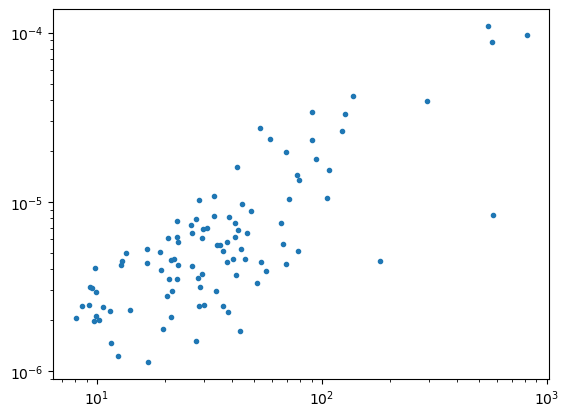

In [192]:
all_errs, all_condition_numbers = [], []
for eps in np.logspace(-5, 0, 100):
    a = np.random.normal(size=(10, 10))
    a[1, 0] = a[0, 0] + eps
    b = np.random.normal(size=10)

    x = np.linalg.solve(a, b)
    x_prime = np.linalg.solve(a, b + 1e-6)
    err = np.linalg.norm(x_prime - x)

    all_errs.append(err)
    all_condition_numbers.append(np.linalg.cond(a))


plt.loglog(all_condition_numbers, all_errs, '.')
plt.xlabel("Condition number")
plt.ylabel("Error of inversion")
plt.show()







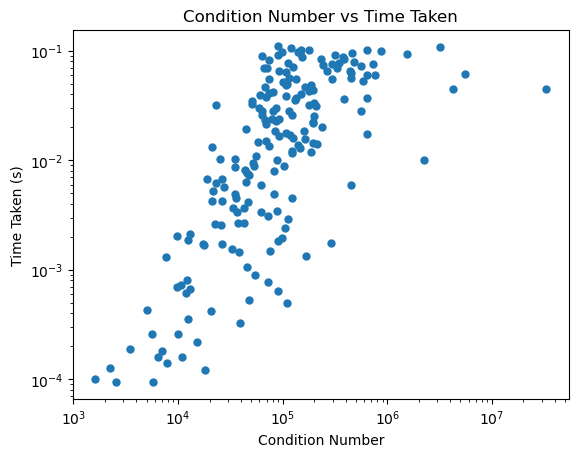

In [193]:
import time

sizes = np.arange(100, 2000, 10)
condition_numbers = []
times = []
for n in sizes:
    # Generate a random matrix and a random vector
    A = np.random.rand(n, n)
    b = np.random.rand(n)
    
    # Compute the condition number
    cond_num = np.linalg.cond(A)

    # Measure the time to solve the system
    start_time = time.time()
    np.linalg.solve(A, b)
    end_time = time.time()
    
    # Store the time taken and condition number
    condition_numbers.append(cond_num)
    times.append(end_time - start_time)

plt.figure()
plt.loglog(condition_numbers, times, '.', markersize=10)
plt.xlabel('Condition Number')
plt.ylabel('Time Taken (s)')
plt.title('Condition Number vs Time Taken')
plt.show()

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

### Functional reduncancy *is* ill conditioning

+ Unlike $\epsilon$, which is a property of our particular model for generating interaction matrices $A$, the condition number is a property we can measure from *any* interaction $A$.

+ Two nearly-parallel rows of $A$ is equivalent to two species being nearly-redundant (interchangeable in the community).

Text(0, 0.5, 'Condition Number')

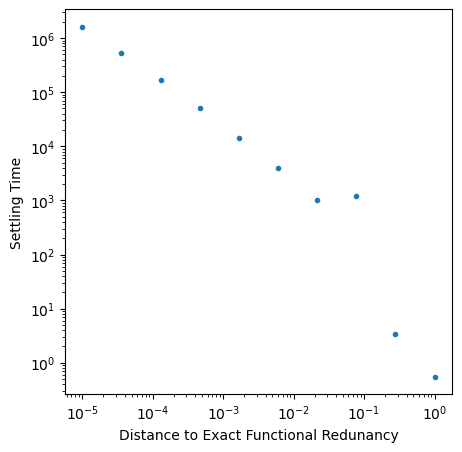

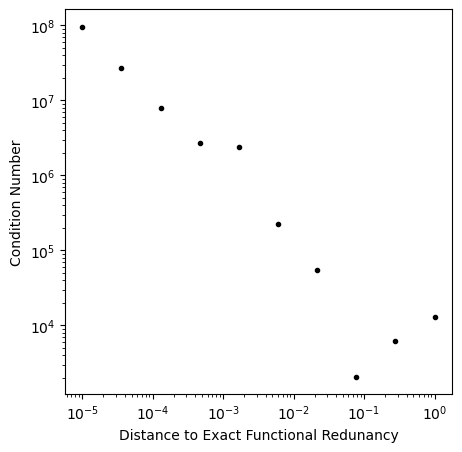

In [ ]:
tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
condition_numbers = []
for eps in eps_vals:
    print(f"eps: {eps}")
    eq = RandomLotkaVolterra(n_val, random_state=0, eps=eps,  sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])
    condition_numbers.append(np.linalg.cond(eq.A))


plt.figure(figsize=(5, 5))
plt.loglog(eps_vals, settling_times, '.')
plt.xlabel("Distance to Exact Functional Redunancy")
plt.ylabel("Settling Time")

plt.figure(figsize=(5, 5))
plt.loglog(eps_vals, condition_numbers, '.k')
plt.xlabel("Distance to Exact Functional Redunancy")
plt.ylabel("Condition Number")



Text(0, 0.5, 'Settling Time')

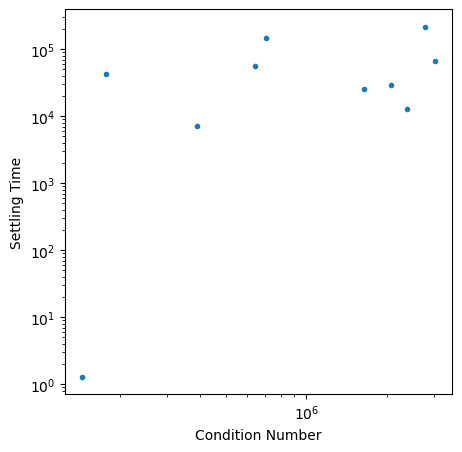

In [7]:
tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
condition_numbers = []
for i in range(10):
    progress_bar(i, 20)
    eq = RandomLotkaVolterra(n_species=n_val, random_state=i, eps=np.random.exponential(scale=1e-3), sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    # eq = GaussianLotkaVolterra(n_val, random_state=seed)
    # eq.A = 1.5 * normal_generalized(size=(n_val, n_val), beta=np.random.exponential(scale=0.5)) - d * np.identity(n_val)
    # eq.r = normal_generalized(size=n_val)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])
    condition_numbers.append(np.linalg.cond(eq.A))

plt.figure(figsize=(5, 5))
plt.loglog(condition_numbers, settling_times, '.')
plt.xlabel("Condition Number")
plt.ylabel("Settling Time")


# Krylov bound on linear solvers

For an iterative linear solver, the convergence time is given by

$$
    \tau \propto \log\bigg( \frac{\kappa(A) - 1}{\kappa(A) + 1} \bigg)^{-1}
$$

See [Trefethen and Bau (1997)](https://www.stat.uchicago.edu/~lekheng/courses/309/books/Trefethen-Bau.pdf).



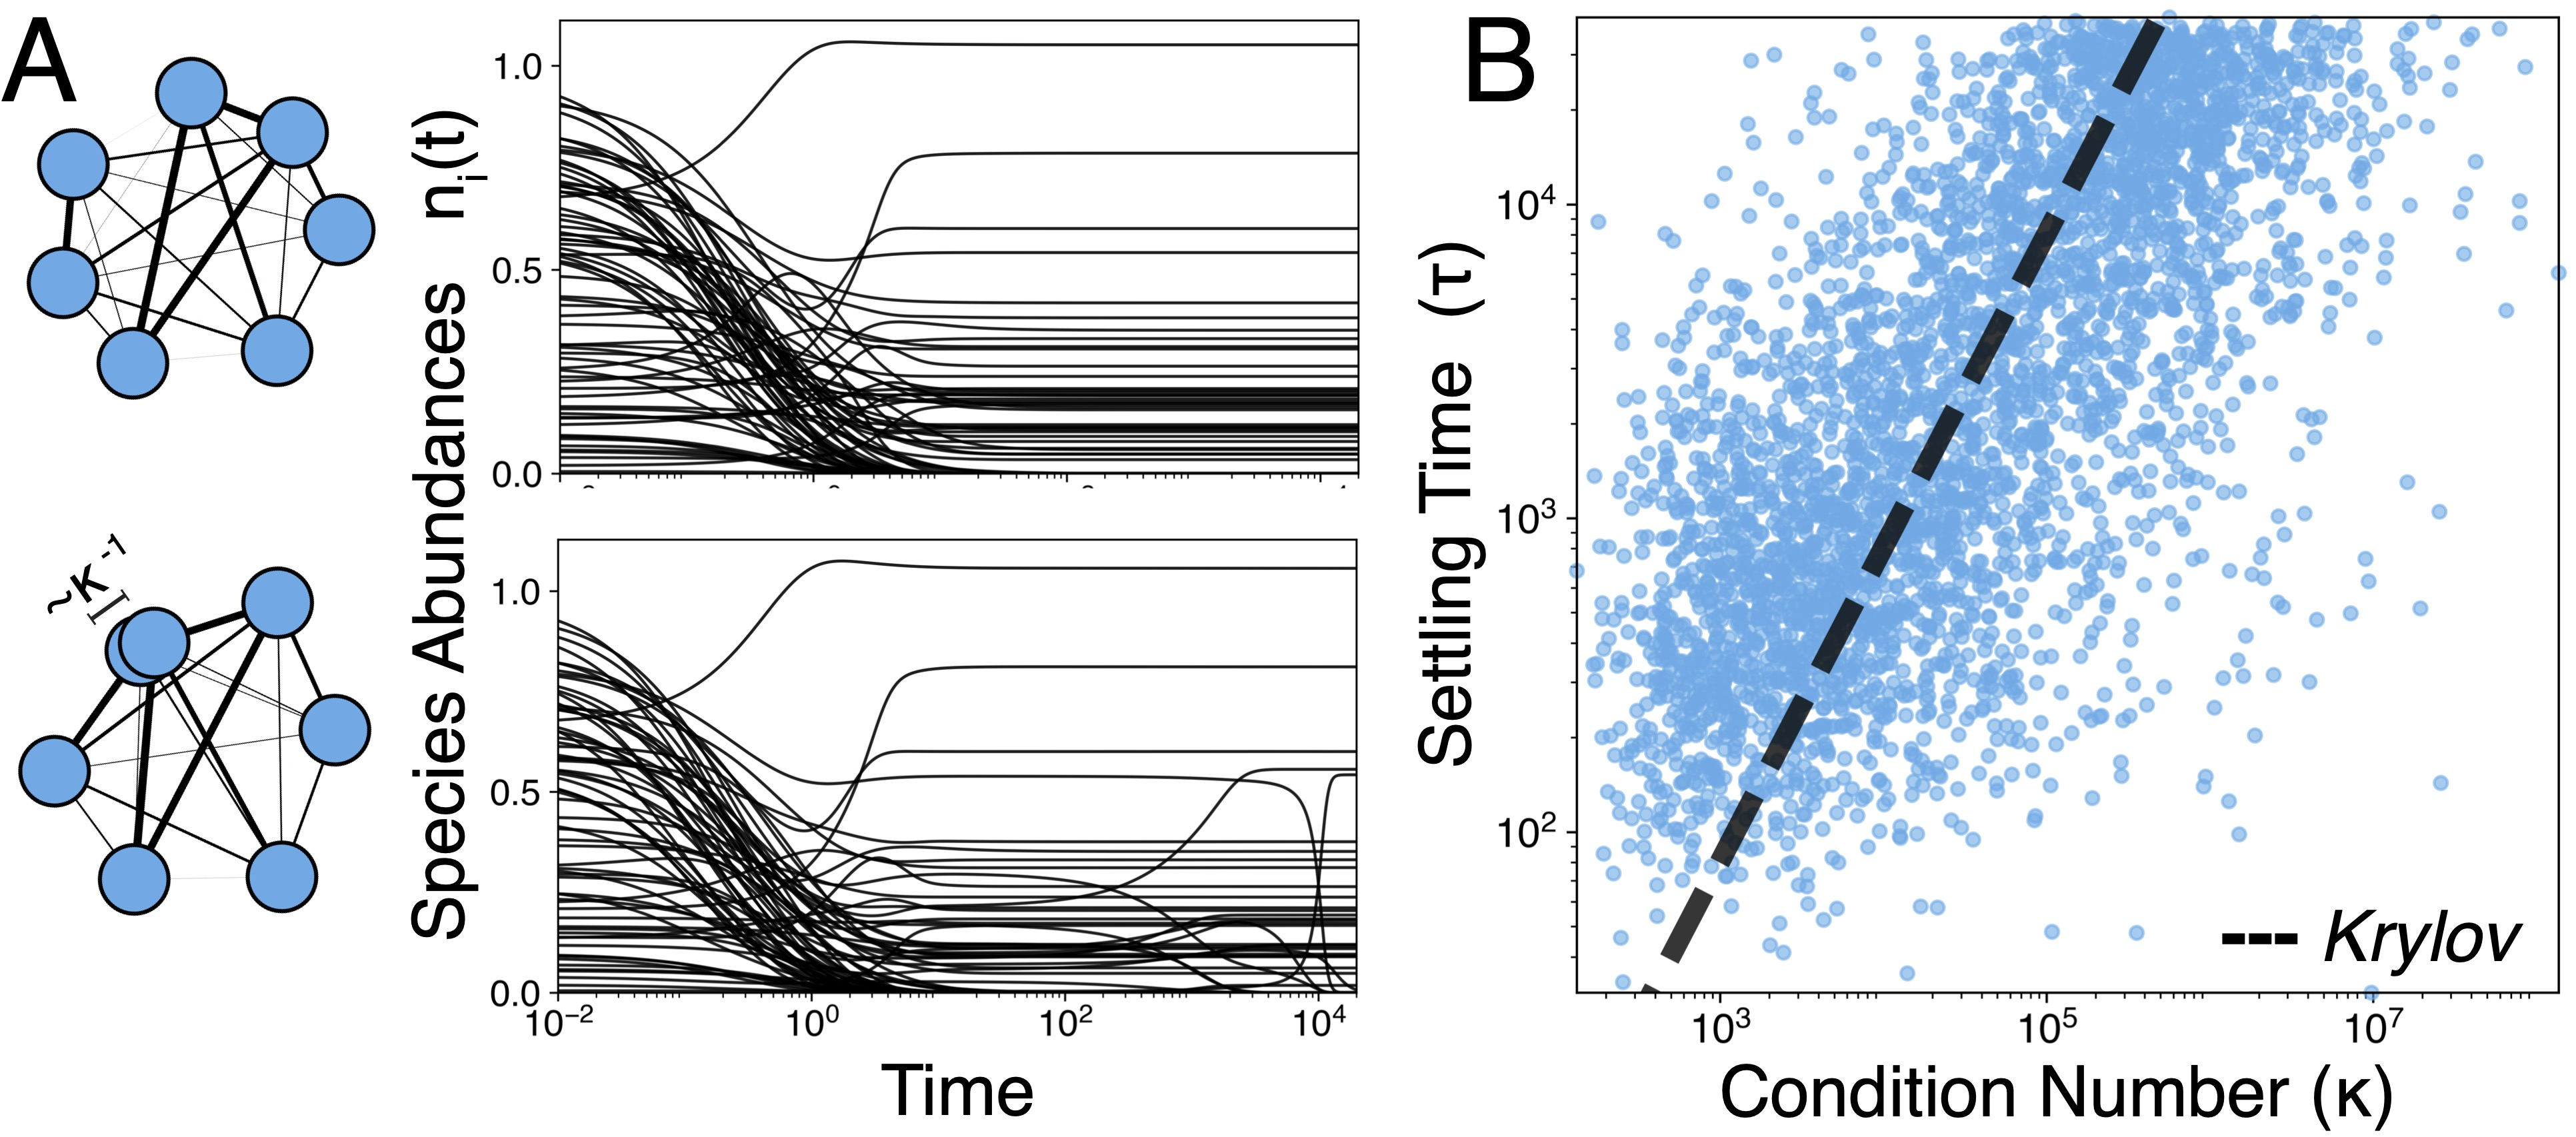

In [10]:
## Loads a figure from the resources folder
Image("./resources/fig_overview.jpg", width=1200)

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>


# How does the settling time depend on the number of species?







In [176]:

n_vals = np.unique(5 * np.logspace(0, 2, 10).astype(int)) # Range of species numbers to consider
tmax = 1e6 # Maximum integration time


## Loop over species numbers and compute the settling time for each
all_t = []
all_y = []
settling_times = []
for i, n_val in enumerate(n_vals):
    progress_bar(i, len(n_vals))

    eq = RandomLotkaVolterra(
        n_species=n_val, 
        random_state=0, 
        eps=1e-3, 
        sigma=2.0, 
        d=6.5, 
        kfrac=0.2, 
        connectivity=0.05
    )
    ic = np.random.uniform(size=eq.n)
    t, y = eq.integrate(tmax, ic)
    all_t.append(t.copy())
    all_y.append(y.copy())
    
    tind = compute_settling_time(y)
    if not np.isnan(tind):
        settling_times.append(t[tind])
    else:
        settling_times.append(np.nan)


[#################   ] 



(10.0, np.float64(1265833.0390973415))

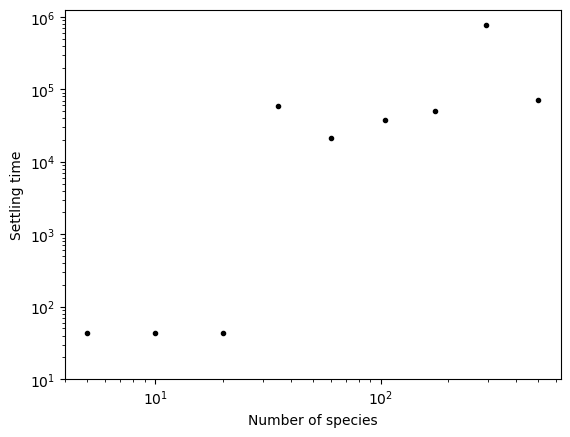

In [178]:
plt.loglog(n_vals, settling_times, '.k')
plt.xlabel("Number of species")
plt.ylabel("Settling time")
# plt.xlim(None, 1000)
plt.ylim(1e1, None)

# Supertransients arise in hard optimization problems

+ Chimeras in the Kuramoto model
+ Pipe turbulence
+ Couple map lattices
+ Continuous time KSAT solvers

# Dimensionality reduction as preconditioning

+ What if we project the dynamics into a lower-dimensional space?

+ We start from our dynamics in the full $N$-dimensional space

$$
    \dot{\mathbf{N}} = \mathbf{f}(\mathbf{N})
$$

+ We can instead study the projected by finding a projection operator $P \in \mathbb{R}^{N \times k}$, $k \ll N$, that projects the dynamics into a lower-dimensional space of dimension $k$

    $$
        \mathbf{x} \equiv P \mathbf{N}, \quad \dot{\mathbf{x}} = P \dot{\mathbf{N}}
    $$

    where $\mathbf{x}(t) \in \mathbb{R}^k$ is a lower-dimensional state vector.


(0.01, np.float64(794328234.7242821))

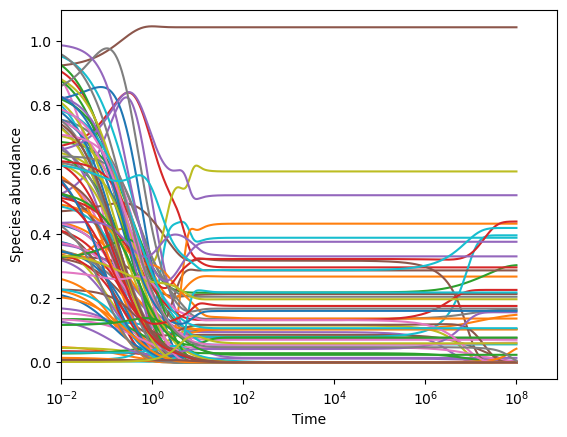

In [17]:
## Start by simulating a full-dimensional state vector

n_val = 200
eq = RandomLotkaVolterra(100, random_state=0)
ic = np.random.uniform(size=eq.n)
t, y = eq.integrate(tmax, ic)

plt.figure()
plt.semilogx(t, y);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, None)


## How to choose a good projection $P$?

+ Since ill-conditioning leads to timescale separation, we seek a projection $P$ satisfying the following properties:

$$
    \kappa(P A) \ll \kappa(A)
$$

+ In numerical analysis, this is known as a preconditioner. If we have a stiff or ill-conditioned linear system, we can precondition it with an appropriate choice of $P$.

+ In PDEs, spectral methods can be thought of as a preconditioner. Some problems are ill-conditioned in the physical space, well-conditioned in the Fourier space.


In [64]:
print(f"The condition number of the full system is {np.linalg.cond(eq.A)}")

The condition number of the full system is 19686952.699464306


## Singular value decomposition

+ Every matrix $A$ can be decomposed into a product of three matrices:

$$
    A = U \Sigma V^\top
$$

+ where $U \in \mathbb{R}^{N \times N}$ and $V \in \mathbb{R}^{N \times N}$ are orthogonal matrices (rotation matrices), and $\Sigma \in \mathbb{R}^{N \times N}$ is a diagonal matrix of positive singular values (in decreasing order).

+ We view $U$ as a rotation matrix that rotates our problem into more favorable coordinates.

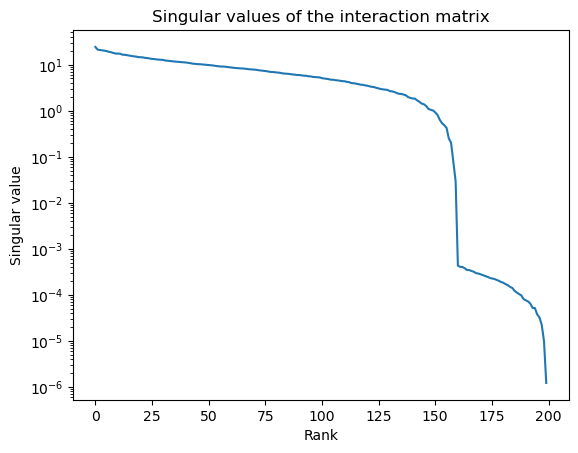

In [69]:
U, S, V = np.linalg.svd(eq.A)

plt.figure()
plt.plot(S);
plt.xlabel("Rank")
plt.ylabel("Singular value")
plt.title("Singular values of the interaction matrix")
plt.semilogy();


### How do we interpret the orthogonal matrices $U$ and $V$?

+ The right singular vectors $V_i$ isolate modes with dynamical timescales $\tau_i \sim 1 / \sigma_i$.


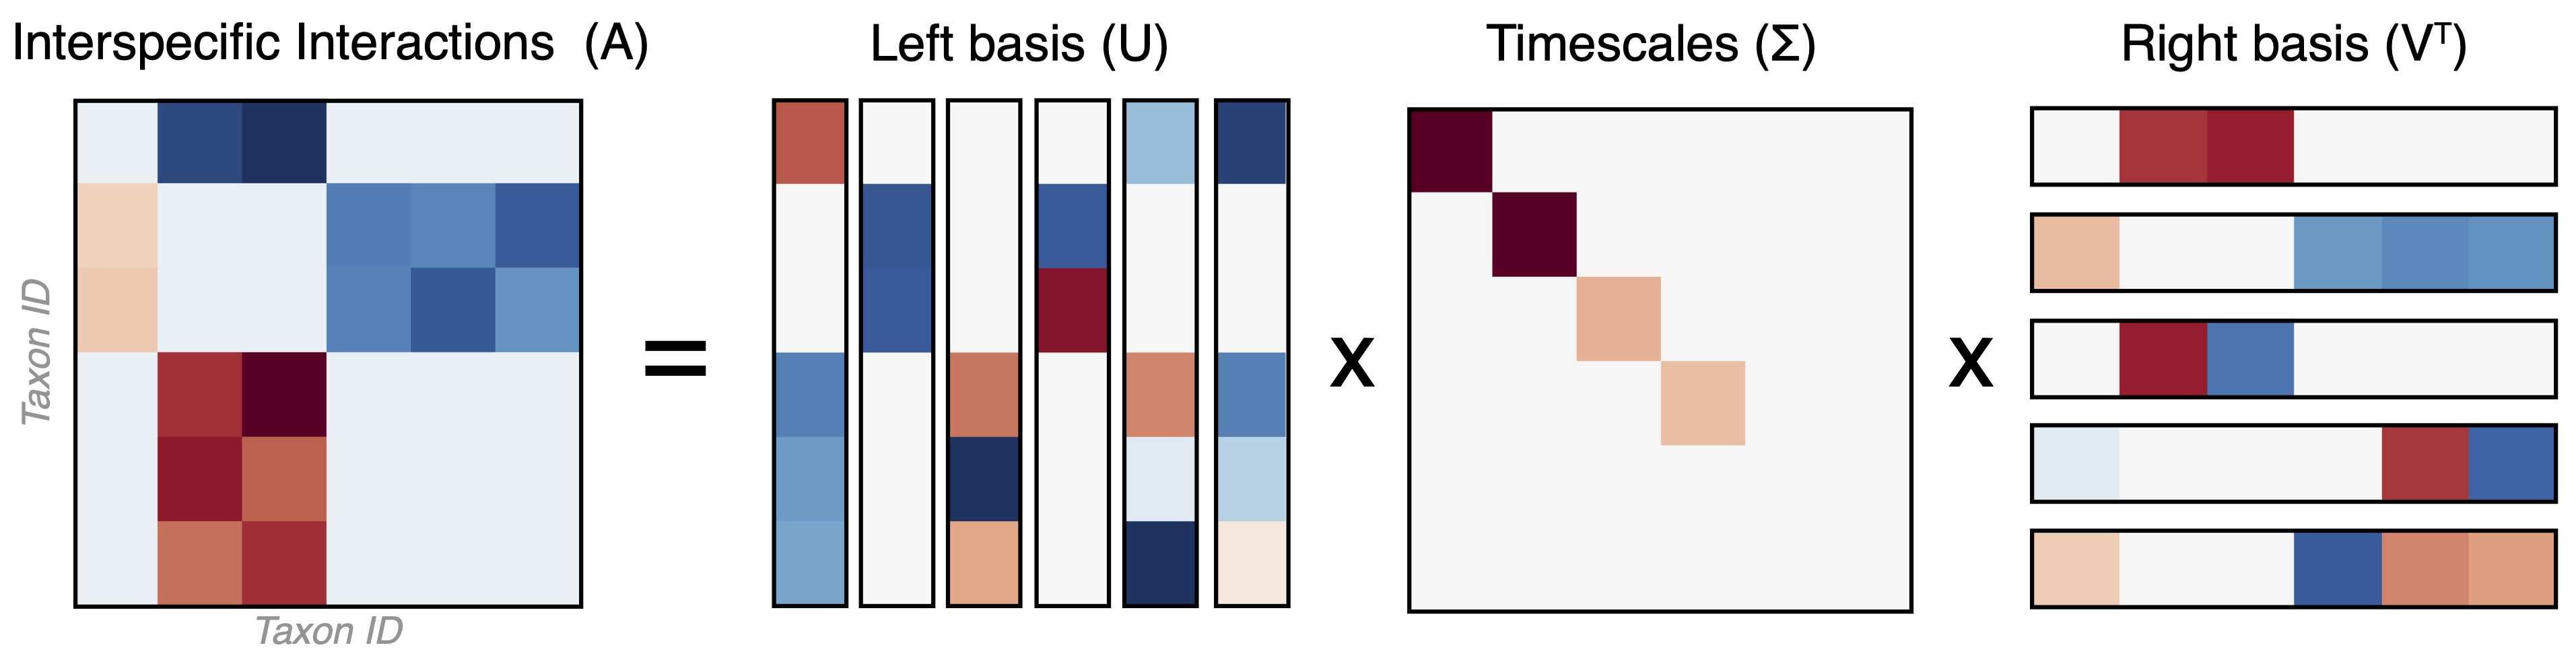

In [22]:
## Loads a figure from the resources folder
Image("./resources/fig_svd.jpg", width=1200)

(0.01, np.float64(2542579.412082511))

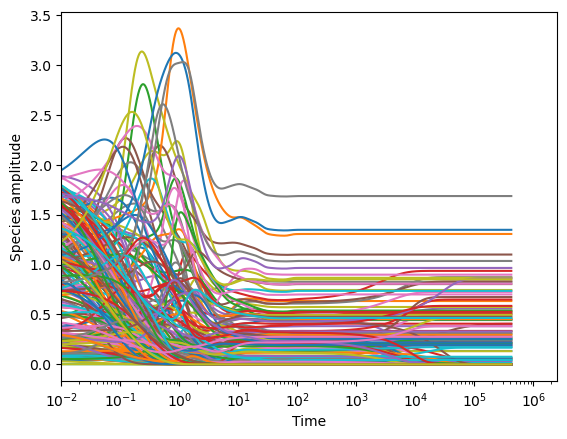

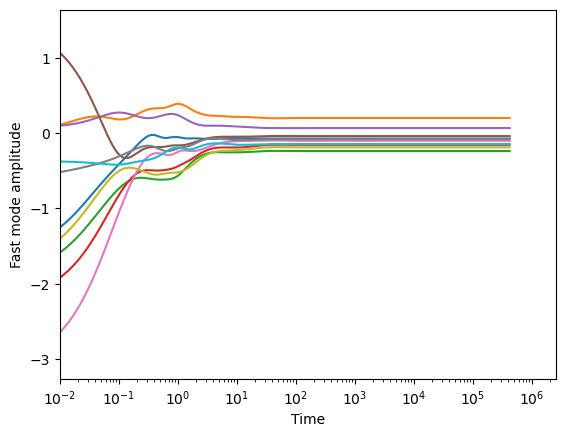

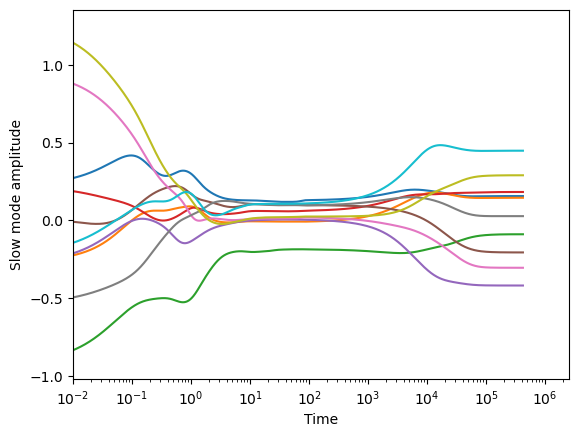

In [70]:
U, S, V = np.linalg.svd(eq.A)
P_fast, P_slow = V[:10, :], V[-10:, :]

yp_fast = P_fast @ y.T # First k modes
yp_slow = P_slow @ y.T # Last k modes


plt.figure()
plt.semilogx(t, y);
plt.xlabel("Time")
plt.ylabel("Species amplitude")
plt.xlim(1e-2, None)


plt.figure()
plt.semilogx(t, yp_fast.T);
plt.xlabel("Time")
plt.ylabel("Fast mode amplitude")
plt.xlim(1e-2, None)

plt.figure()
plt.semilogx(t, yp_slow.T);
plt.xlabel("Time")
plt.ylabel("Slow mode amplitude")
plt.xlim(1e-2, None)
plt.xlabel("Time")
plt.ylabel("Slow mode amplitude")
plt.xlim(1e-2, None)




**Preconditioning:** We can compute the condition number of the dynamics projected into the subspaces spanned by the fast and slow modes.

$$
    A_\text{slow} = P_\text{slow}^\top A P_\text{slow}
$$

For a linear dynamical system, this would also correspond to the Jacobian of the projected system.



In [26]:
print("Original condition number: ", np.linalg.cond(eq.A))

print("Fast modes condition number: ", np.linalg.cond(P_fast @ eq.A @ P_fast.T))
print("Slow modes condition number: ", np.linalg.cond(P_slow @ eq.A @ P_slow.T))

Original condition number:  4429801842.761199
Fast modes condition number:  1.5851693011189856
Slow modes condition number:  153.51209647795702


Why does this work? The condition number alternatively can be expressed as the ratio of the largest and smallest singular values of the matrix.

$$
    \kappa(A) = \frac{\sigma_{\text{max}}(A)}{\sigma_{\text{min}}(A)}
$$


How general is this? Check out Weyl's inequalities discussed in [Thibeault et al. 2024](https://www.nature.com/articles/s41567-023-02303-0).

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>

# When would ill-conditioning emerge in a random ecosystem?

+ We revisit the case where the dynamics are not ill-conditioned, the Gaussian Lotka-Volterra model.


The number of surviving species is 49 out of 100


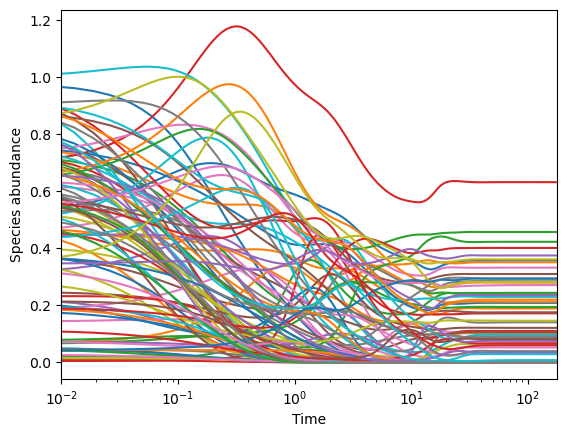

In [150]:

eq = GaussianLotkaVolterra(
    n=100, 
    d=8.5,
    random_state=0,
)
tmax = 1000
ic = np.random.uniform(size=eq.n)

t, y = eq.integrate(tmax, ic)

plt.figure()
plt.semilogx(t, y);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, t[-1])


print(f"The number of surviving species is {np.sum(y[-1] > 1e-2)} out of {eq.n}")


+ We now perform a simple evolutionary algorithm to evolve the ecosystem to have more surviving species.

+ We start with a random interaction matrix, simulate the ecosystem, and find the surviving species.

+ If a species is excluded from the ecosystem, we replace it in the next generation with a new species with interactions averaged from two randomly chosen surviving species.

+ If $i$ is the index of the extinct species, $j$ and $k$ are the indices of the two surviving species, and $a_{ij}$ is the interaction between species $i$ and $j$, we update the interaction matrix as

    $$
        a_{ik} = 0.05 a_{ij} + 0.95 a_{ik}
    $$

+ We repeat this process for 100 generations.



In [151]:
all_fitnesses = []
all_condition_numbers = []
for j in range(100):

    ## Simulate the ecosystem with the current interaction matrix
    t, y = eq.integrate(tmax, ic)
    sol = y[-1]
    
    ## Find the surviving species
    where_survive = (sol > 1 / eq.n)
    surviving_inds = np.where(where_survive)[0] 
    extinct_inds = np.setdiff1d(np.arange(eq.n), surviving_inds)


    ## Recombination: replace extinct species with new species averaged from surviving species
    new_matrix = eq.A.copy()
    for i in extinct_inds:
        parent_ind1, parent_ind2 = np.random.choice(surviving_inds, size=2, replace=False)
        interaction_ind = np.random.choice(np.setdiff1d(np.arange(eq.n), [parent_ind1, parent_ind2, i]))
        new_matrix[i] = eq.A[i]
        new_matrix[i, interaction_ind] = 0.5 * eq.A[parent_ind1, interaction_ind] + 0.5 * eq.A[parent_ind2, interaction_ind]

    ## Update the interaction matrix
    eq.A = new_matrix.copy()
    fitness = np.sum(where_survive)
    print(f"Iteration {j}: The number of surviving species is {fitness} out of {eq.n}")

    ## Save the fitness and condition number for this generation
    all_fitnesses.append(np.sum(where_survive))
    all_condition_numbers.append(np.linalg.cond(eq.A[surviving_inds][:, surviving_inds]))

Iteration 0: The number of surviving species is 49 out of 100
Iteration 1: The number of surviving species is 50 out of 100
Iteration 2: The number of surviving species is 52 out of 100
Iteration 3: The number of surviving species is 53 out of 100
Iteration 4: The number of surviving species is 53 out of 100
Iteration 5: The number of surviving species is 54 out of 100
Iteration 6: The number of surviving species is 55 out of 100
Iteration 7: The number of surviving species is 55 out of 100
Iteration 8: The number of surviving species is 59 out of 100
Iteration 9: The number of surviving species is 59 out of 100
Iteration 10: The number of surviving species is 57 out of 100
Iteration 11: The number of surviving species is 56 out of 100
Iteration 12: The number of surviving species is 58 out of 100
Iteration 13: The number of surviving species is 59 out of 100
Iteration 14: The number of surviving species is 57 out of 100
Iteration 15: The number of surviving species is 59 out of 100
It

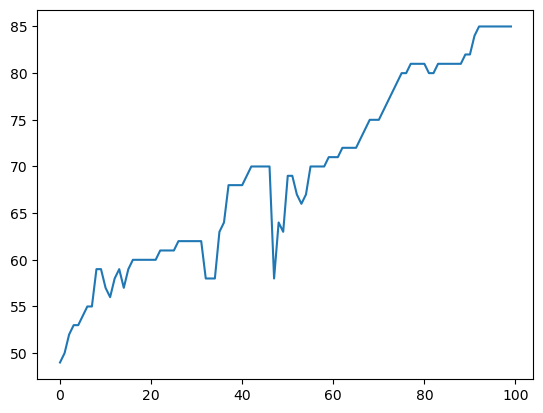

In [152]:
plt.plot(all_fitnesses);

Text(0, 0.5, 'Condition number')

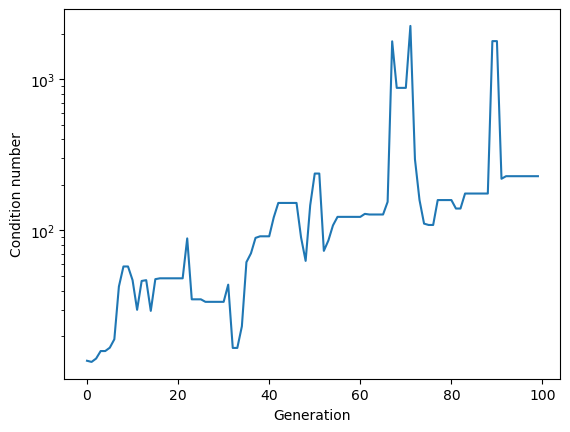

In [155]:
plt.semilogy(all_condition_numbers)
plt.xlabel("Generation")
plt.ylabel("Condition number")


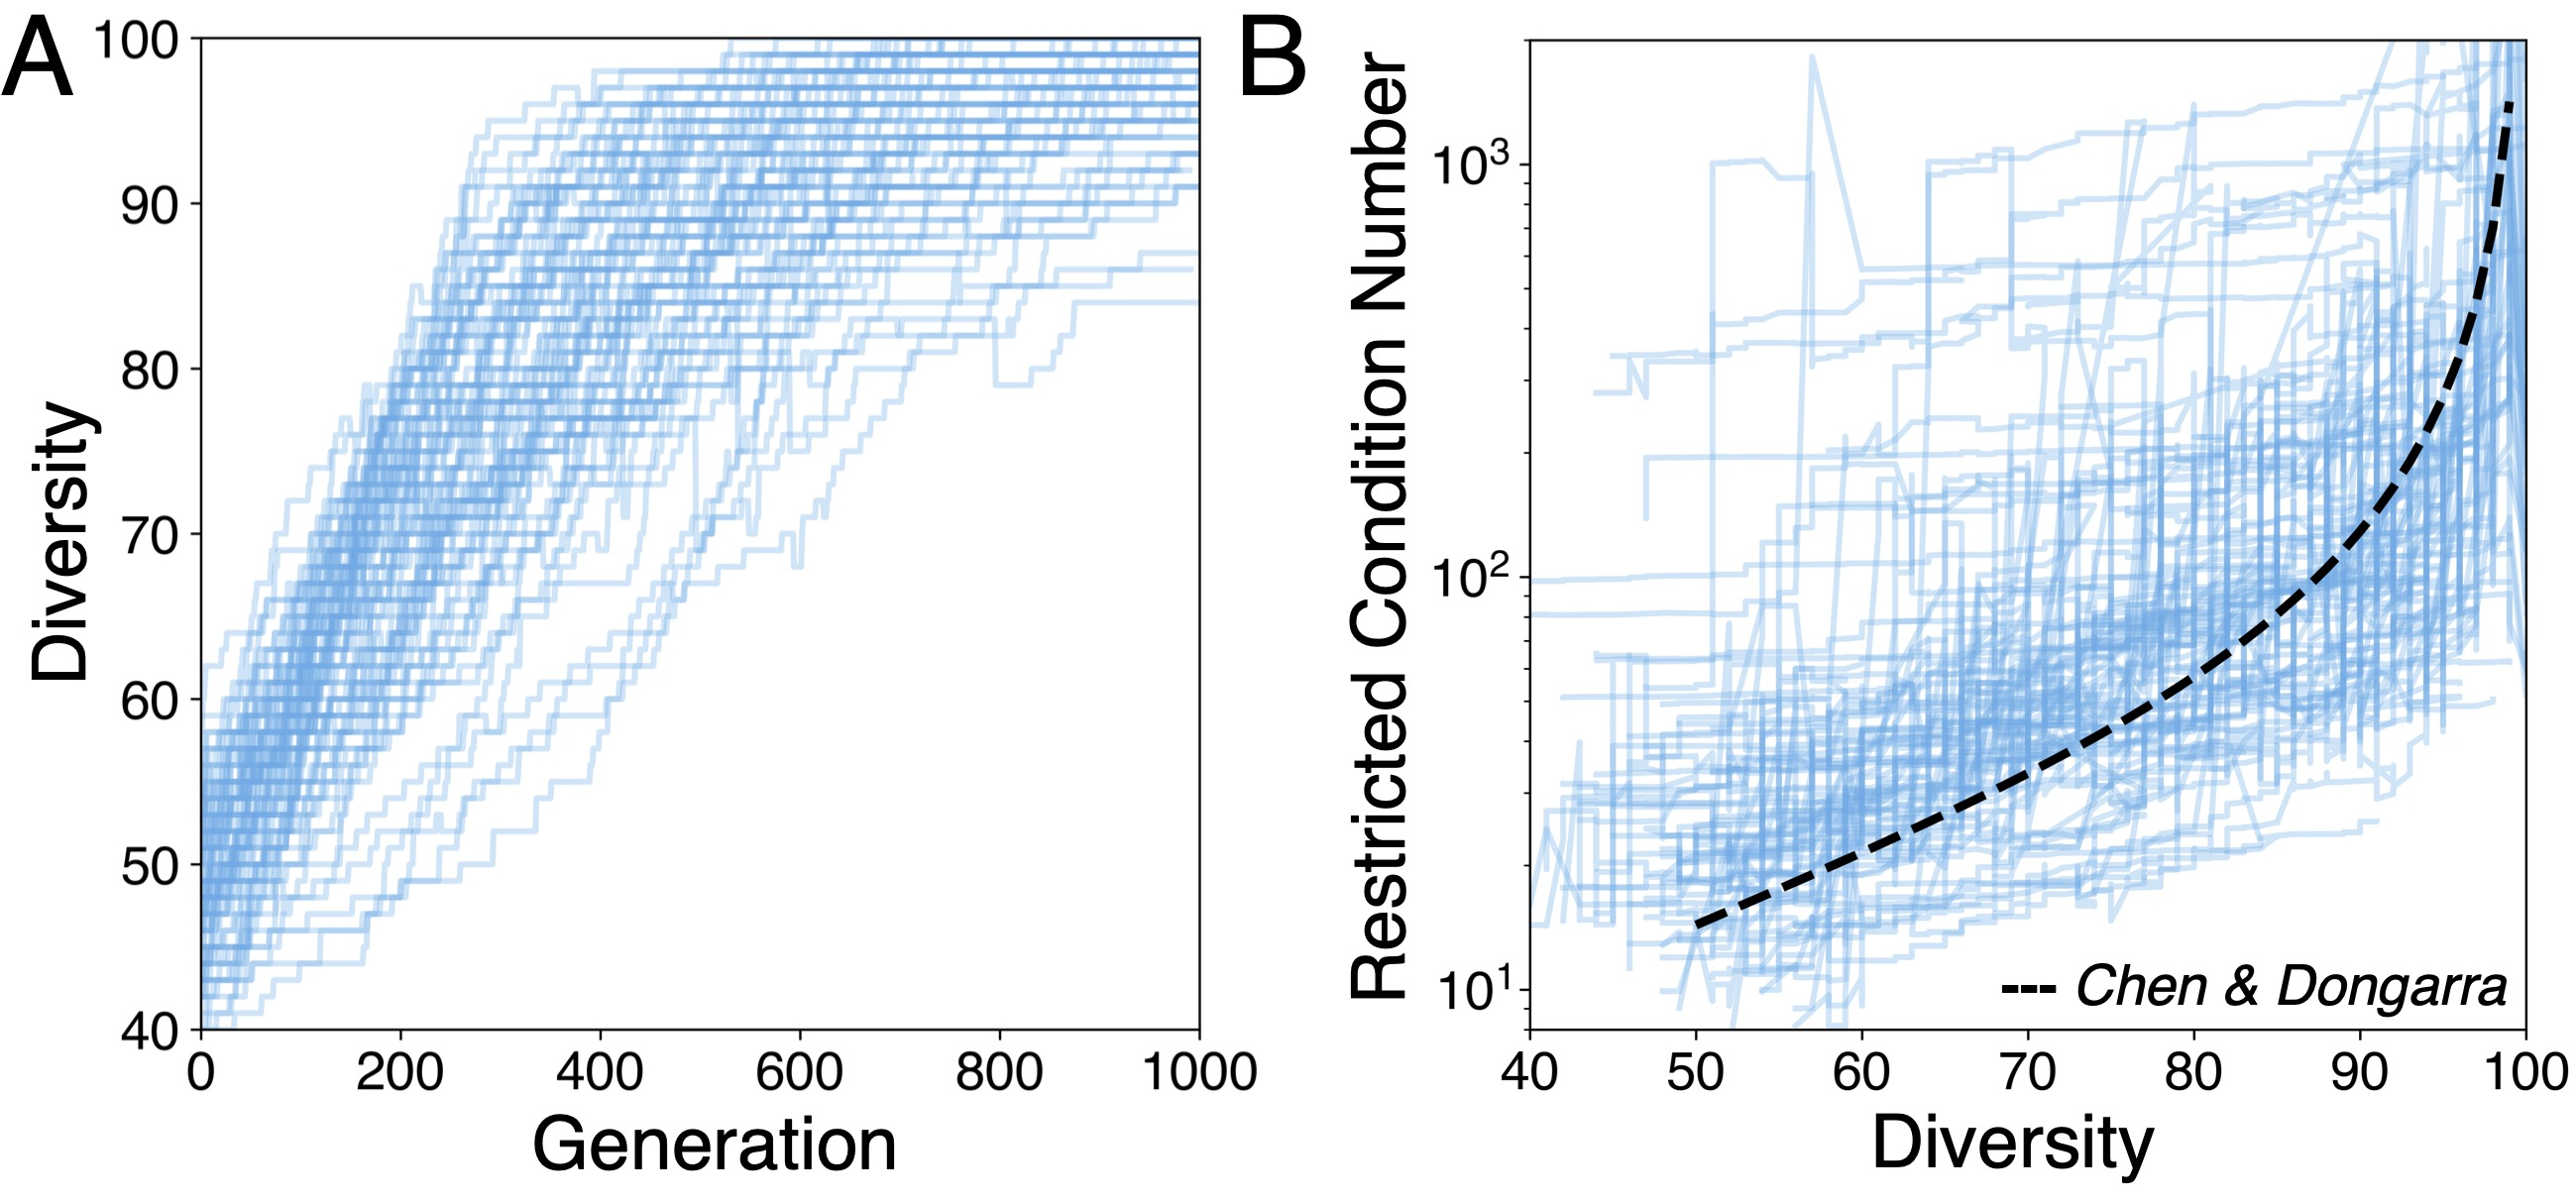

In [12]:
## Loads a figure from the resources folder
Image("./resources/fig_evolve.jpg", width=1200)

### How do transients depend on the initial conditions?


In [ ]:
tmax = 1e8 ## Maximum integration time

eq = RandomLotkaVolterra(
    n_species=n_val, # Number of species
    sigma=2.0, # Amplitude of interactions
    d=4.5, # Density-limitation strength
    kfrac=0.5, # Fraction redundant interactions
    eps=0.00005, # Functional redundancy
    random_state=0, # Random seed
    connectivity=0.05 # Connectivity of network
)

ic = 2*np.random.uniform(size=eq.n)
tlim = (0, 50000)
t, y = eq.integrate(tmax, ic)
plt.figure()
plt.semilogx(t, y, color="r", linewidth=0.8);

ic += 1e-3
t, y = eq.integrate(tmax, ic)
plt.semilogx(t, y, color="k", linewidth=0.8);

plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, t[-1])

# settling_time = compute_settling_time(y)
# print(f"Settling time: {t[settling_time]:.2f}")



In [ ]:
n1_val = np.linspace(0, 1, 100)
n1_val = np.linspace(0.2, 0.3, 100)
n1_val = np.linspace(0.2, 0.21, 100)
icp = ic.copy()
all_sol = []
for i, n1 in enumerate(n1_val):
    progress_bar(i, len(n1_val))
    icp[0] = n1
    t, y = eq.integrate(tmax, icp)
    all_sol.append([y, t])



    


In [ ]:
U, S, V = np.linalg.svd(eq.A)
# P = U[:, :10].T
# P1 = U[:, -10:].T
P_fast, P_slow = V[:10, :], V[-10:, :]
# P_slow = P_slow.T
def instantaneous_fli(y, t, dt, jac):
    
    # P2 = P_slow @ jac(t, y) @ P_slow.T

    # # ## Finite difference approximation of Jacobian
    eps = 1e-8
    jac_fd = np.zeros((P_slow.shape[0], P_slow.shape[0]))
    for i in range(jac_fd.shape[0]):
        pt0, pt1 = y.copy(), y.copy()
        pt1[i] += eps
        jac_fd[:, i] = (P_slow @ (eq(0, pt1) - eq(0, pt0))) / (P_slow @ (pt1 - pt0))
        # jac_fd[:, i] = (P_fast @ (eq(0, pt1) - eq(0, pt0))) / (P_fast @ (pt1 - pt0))
    jac_fd = np.array(jac_fd)
    P2 = jac_fd

    # Finite‐difference reduction:
    
    # eps = 1e-8
    # n_slow = P_slow.shape[1]   # should be 10
    # J_reduced_fd = np.zeros((n_slow, n_slow))
    # f0 = eq(0, y)  # baseline 100‐vector
    # for j in range(n_slow):
    #     p_j = P_slow[:, j]              # 100‐vector (slow direction j)
    #     y_perturbed = y + eps * p_j     # perturb along the jth slow basis
    #     f1 = eq(0, y_perturbed)         # 100‐vector
    #     # directional derivative of f in direction p_j:
    #     df_dp = (f1 - f0) / eps         # 100‐vector ≈ J_full @ p_j
    #     # project onto slow‐coordinates on the left:
    #     J_reduced_fd[:, j] = P_slow.T @ df_dp   # 10‐vector
    # P2 = J_reduced_fd

    # Let U[k, :] be the k-th slow‐mode represented as a 100‐vector.
    # U = P_slow.T       # shape (10, 100)
    # U = P_slow.T
    # J_full = jac(t, y)
    # # print(J_full.shape, U.shape)
    # # Preallocate the “scaled‐projection” matrix:
    # #   jac_fd[k, j] = (U[k, :] · (J_full[:, j])) / U[k, j]
    # n_modes, dim = U.shape
    # jac_fd  = np.zeros((n_modes, dim))

    # numerator = U @ J_full  # (10, 100)
    # # We only need the first n_modes columns (j=0..n_modes-1) to match the original FD over 10 coordinates.
    # # Denominator = U[:, :n_modes] (shape: 10 × 10)
    # num_slice = numerator[:, :n_modes]  # (10, 10)
    # den_slice = U[:, :n_modes]       # (10, 10)
    # # Compute jac_fd[k, j] = (u_k^T · (J_full · e_j)) / u_{k,j} for j=0..n_modes-1
    # jac_fd = num_slice / den_slice  # shape: (10, 10)
    # P2 = jac_fd

    

    Q = np.linalg.inv(np.eye(P2.shape[0]) - dt * P2)
    eigenvalues = np.linalg.eigvalsh(Q.T @ Q)
    fli_val = np.sqrt(np.max(eigenvalues))
    return fli_val


def find_fli(sol, tvals, jac):
    dtvals = np.diff(tvals)
    dtvals = np.hstack([dtvals, dtvals[-1]])
    fli = -np.inf
    for yval, dt, tval in zip(sol, dtvals, tvals):
        fli = max(fli, instantaneous_fli(yval, tval, dt, jac))
    return fli

all_fli = []
for sol, tvals in all_sol:
    all_fli.append(find_fli(sol, tvals, eq.jac))

plt.plot(n1_val, all_fli);


In [ ]:
# n_res = 120
# n_res = 100
# n_res = 10
n_res = 10
# n_res = 10
# n_res = 25
# n_res = 10
# n_res = 5
# x = np.linspace(0.2, 0.202, n_res)
# y = np.linspace(0.2, 0.202, n_res)
x = np.linspace(0.2, 0.3, n_res)
y = np.linspace(0.2, 0.3, n_res)
x = np.linspace(0.0, 1.0, n_res)
y = np.linspace(0.0, 1.0, n_res)
xx, yy = np.meshgrid(x, y)
xx, yy = xx.ravel(), yy.ravel()
pts = np.vstack([xx, yy]).T

## Fixed disorder in initial conditions
np.random.seed(0)
# ic0 = np.random.uniform(size=eq.n)
icax = np.random.uniform(size=eq.n) * np.max(sol_final)
icbx = np.random.uniform(size=eq.n) * np.max(sol_final)
icay = np.random.uniform(size=eq.n) * np.max(sol_final)
icby = np.random.uniform(size=eq.n) * np.max(sol_final)



all_fli = []
for i, ic_val in enumerate(pts):
    progress_bar(i, len(pts))
    ic = bilinear_interpolation(icax, icbx, icay, icby, ic_val[0], ic_val[1])
    ic[ic < 0] = 0.0
    # print(ic[0])
    t, y = eq.integrate(tmax, ic, tolerance=1e-10)
    fli = find_fli(y, t, eq.jac)
    all_fli.append(fli)
    

ms = 1200 * (20 / n_res)**2
plt.figure(figsize=(8,8))
all_fli = np.array(all_fli).astype(float)
vmin = np.percentile(all_fli, 5)
vmax = np.percentile(all_fli, 95)
plt.scatter(pts[:, 0], pts[:, 1], c=all_fli, s=ms, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.axis("off")

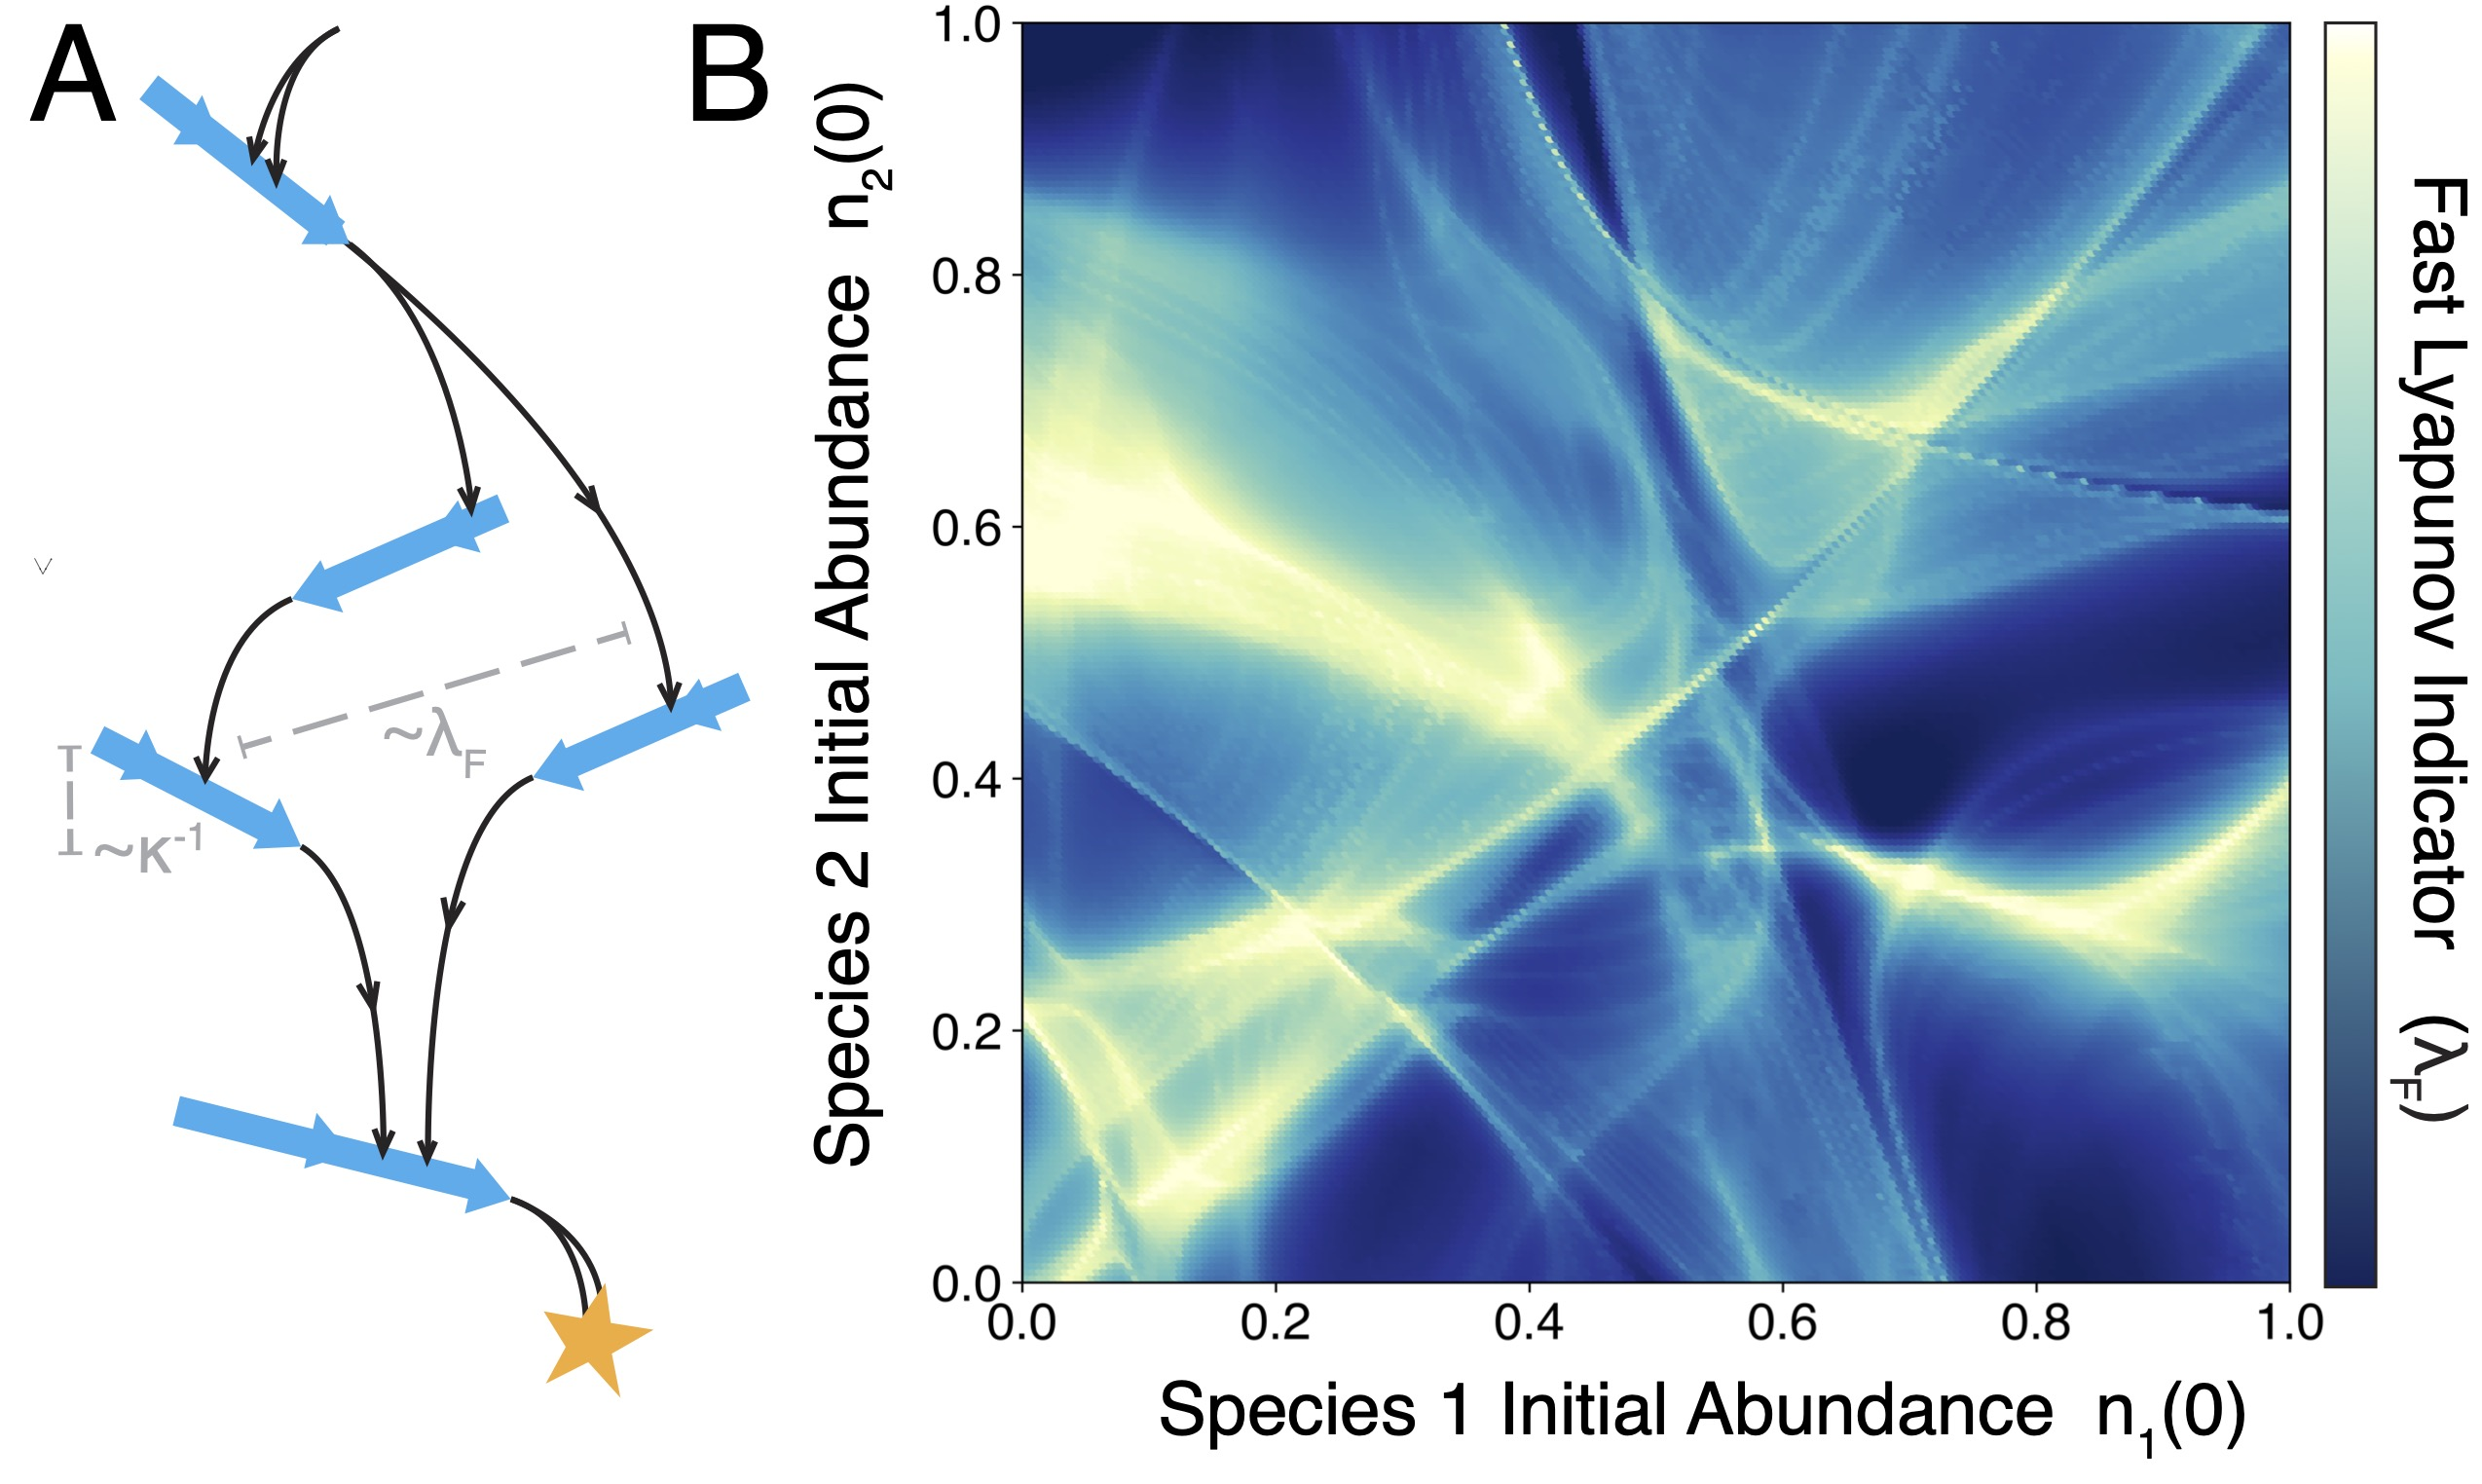

In [179]:
## Loads a figure from the resources folder
Image("./resources/fig_chaos.jpg", width=1200)

In [ ]:
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

# What sets the hardness of linear regression?


We can write a linear regression system of the form $A \mathbf{N} = -\mathbf{r}$ in terms of column vectors of $A$ and $\mathbf{r}$.

If 
$$
    A = \begin{bmatrix}
        \mathbf{a}_1 & \mathbf{a}_2 & \cdots & \mathbf{a}_N
    \end{bmatrix}
$$

Then we seek a solution to

$$
    \mathbf{a}_1 N_1 + \mathbf{a}_2 N_2 + \cdots + \mathbf{a}_N N_N = -\mathbf{r}
$$

We write the objective function as

$$
    \mathcal{L} = \frac{1}{2} \left( \mathbf{a}_1 N_1 + \mathbf{a}_2 N_2 + \cdots + \mathbf{a}_N N_N + \mathbf{r} \right)^2
$$

If we use gradient descent to solve this system, we can write the update rule as

$$
    N_i \leftarrow N_i - \eta \left( \sum_{j=1}^N a_{ij} N_j + r_i \right)
$$

Condition: two row-vector products are very




## The ill-conditioned Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$. The steady-state solutions of this equation has the form

$$
    -A \mathbf{N}^* = \mathbf{r}
$$

where $N_i \geq 0$ for all $i$.

In this notebook, we explore the behavior of this model when the interaction matrix $A_{ij}$, and the growth rates $r_i$ are drawn from random distributions. Specifically, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form

$$
    A = P^\top (Q - d\, I) P + \epsilon E
$$

where $Q_{ij} \sim \mathcal{N}(0,1)$, $E_{ij} \sim \mathcal{N}(0,1)$, $P$ is a low-rank matrix imposing functional redundancy, $d$ is a constant density-limitation, and $\epsilon \ll 1$ is a small constant.


Numerical stability observed: True


Text(0.5, 1.0, 'Eigenvalues of Jacobian')

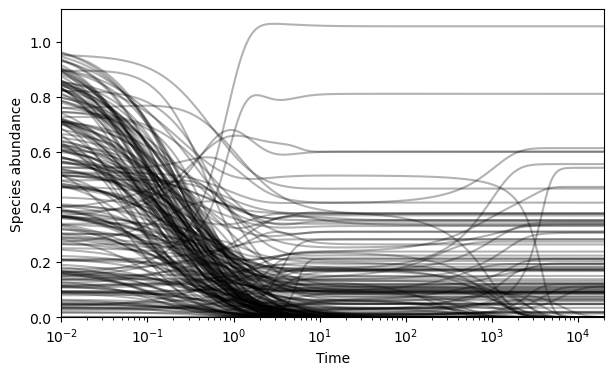

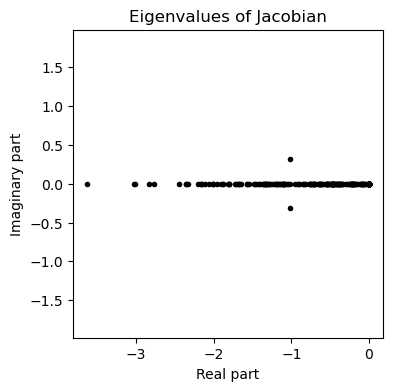

In [8]:
from scipy.integrate import solve_ivp

## Load local functions
import sys
import base
import utils
from base import RandomLotkaVolterra
from utils import levenshtein


tlim = (0, 20000) # Integration interval
n_val = 200 # Number of species

## Initialize the model
eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.001, random_state=0, connectivity=0.01)

## Initial conditions
ic = np.random.uniform(size=eq.n)

## Numerical integration
fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)


## Check that the found solution is stable
sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Numerical stability observed: {np.all(np.real(eigs) < 0)}")

## Plot the solution
plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, fsol.y.T, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(fsol.t))
plt.ylim(0, None)

eigvals = np.linalg.eigvals(jac_final)
plt.figure(figsize=(4, 4))
plt.plot(np.real(eigvals), np.imag(eigvals), '.k')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.axis("equal")
plt.title("Eigenvalues of Jacobian")